<table><tr>
<td> 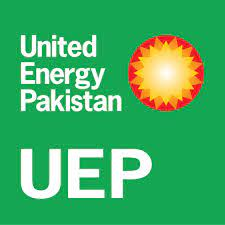 </td>
<td> <img src="https://npc-core.com/npc-content/uploads/2021/03/core-analysis-cores-combo.jpeg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P6163_YE2022_Reserves_Audit </font></h1>
<h1 align=center><font size = 4> Routine Core Analysis </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Display max rows
pd.set_option('display.max_rows', 500)

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\munishkumar-gh.github.io\Core_Analysis_UEP'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )

    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends 
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0, xlimit)
    plt.ylim(0.001, ylimit)
    
    df_sub = df_sub[['Porosity (%)', 'K (mD)']].sort_values(by = 'Porosity (%)', ascending = True)
    
    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] #x-value
    y2 = df_sub["K (mD)"] #y-value 
   
    ## Eqn Fit 1 ##
    # For fitting y = Ax^B, ln y = ln A + B ln x. So fit (ln y) against (ln x).
    # p = np.polyfit(np.log(y1), np.log(y2), 1, w=np.sqrt(y2/2)) # w is weight to bias against larger values of y
    # p = np.polyfit(np.log(y1), np.log(y2), 1)
    # f = np.poly1d(p)

    ## Eqn Fit 2 ##
    # For fitting y = Ae^(Bx), ln y = ln A + Bx. So fit (ln y) against x.
    # p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    p = np.polyfit(y1, np.log(y2), 1)
    f = np.poly1d(p)

    if plot_line_eqn == True: 
        ax.semilogy(y1, np.exp(p[0] * np.log(y1) + p[1]), 'k--', linewidth = 2.5)
        # Display Equation
        plt.text(17.5, 100, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
        plt.title (title, fontsize = size)
    else:
        p[0] = 0
        p [1] = 0
        f = np.poly1d(p)
    
    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    ax.set_yscale('log')

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return f, p[0], p[1]

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_UEP.xlsx', 
    header=[0, 1], 
    sheet_name='MASTER', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K (mD)', 'Porosity (%)', 'Grain Density (g/cc)', 'Core Type']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_11648\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


,Well Name,Sample ID,Depth (m),NOB (psi),K (mD),Porosity (%),Grain Density (g/cc),Core Type
0,Khararo_1,1,2968.20,0,1.61,7.95,,CCA
1,Khararo_1,2,2968.30,0,11.5,3.2,2.68,CCA
2,Khararo_1,3,2968.68,0,,11,2.71,CCA
3,Khararo_1,4,2969.20,0,0.01,7.73,,CCA
4,Khararo_1,5,2969.50,0,,,,CCA
5,Khararo_1,6,2969.90,0,0.43,19.97,,CCA
6,Khararo_1,7,2970.48,0,0.7,18,2.71,CCA
7,Khararo_1,8,2971.00,0,0.37,20.06,,CCA
8,Khararo_1,9,2971.12,0,1.2,18.3,2.7,CCA
9,Khararo_1,10,2971.85,0,0.04,9.75,,CCA


##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K (mD)'] > 0]
mod_df = mod_df[mod_df['Grain Density (g/cc)'] > 2.55]
mod_df = mod_df[mod_df['Grain Density (g/cc)'] < 2.85]
mod_df

,Well Name,Sample ID,Depth (m),NOB (psi),K (mD),Porosity (%),Grain Density (g/cc),Core Type
1,Khararo_1,2,2968.30,0,11.500000,3.200000,2.680,CCA
6,Khararo_1,7,2970.48,0,0.700000,18.000000,2.710,CCA
8,Khararo_1,9,2971.12,0,1.200000,18.300000,2.700,CCA
15,Khararo_1,16,3150.18,0,10.400000,7.100000,2.640,CCA
28,Khipro_1,29,3313.40,0,1.350000,10.800000,2.830,CCA
...,...,...,...,...,...,...,...,...
707,Mehar-3,708,3835.16,0,11.200540,7.445728,2.653,CCA
708,Mehar-3,709,3841.05,0,8.784493,7.194769,2.650,CCA
709,Mehar-3,710,3852.74,0,43.876380,12.589561,2.657,CCA
710,Mehar-3,711,3836.28,0,5.647200,5.650368,2.670,CCA


###### Mapping each well to a colour

In [11]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 1 to 711
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             616 non-null    object 
 1   Sample ID             616 non-null    int64  
 2   Depth (m)             616 non-null    float64
 3   NOB (psi)             616 non-null    int64  
 4   K (mD)                616 non-null    float64
 5   Porosity (%)          616 non-null    float64
 6   Grain Density (g/cc)  616 non-null    float64
 7   Core Type             616 non-null    object 
 8   color                 616 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 48.1+ KB


In [12]:
for well in mod_df['Well Name'].unique():
        print(mod_df[mod_df['Well Name'] == well].info())      
        print(mod_df[mod_df['Well Name'] == well].describe(include='all'))       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 1 to 15
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             4 non-null      object 
 1   Sample ID             4 non-null      int64  
 2   Depth (m)             4 non-null      float64
 3   NOB (psi)             4 non-null      int64  
 4   K (mD)                4 non-null      float64
 5   Porosity (%)          4 non-null      float64
 6   Grain Density (g/cc)  4 non-null      float64
 7   Core Type             4 non-null      object 
 8   color                 4 non-null      object 
dtypes: float64(4), int64(2), object(3)
memory usage: 320.0+ bytes
None
        Well Name  Sample ID    Depth (m)  NOB (psi)     K (mD)  Porosity (%)  \
count           4   4.000000     4.000000        4.0   4.000000      4.000000   
unique          1        NaN          NaN        NaN        NaN           NaN   
top     Khararo_1      

In [13]:
print(mod_df.info())
print(mod_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 1 to 711
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             616 non-null    object 
 1   Sample ID             616 non-null    int64  
 2   Depth (m)             616 non-null    float64
 3   NOB (psi)             616 non-null    int64  
 4   K (mD)                616 non-null    float64
 5   Porosity (%)          616 non-null    float64
 6   Grain Density (g/cc)  616 non-null    float64
 7   Core Type             616 non-null    object 
 8   color                 616 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 48.1+ KB
None
       Well Name   Sample ID    Depth (m)  NOB (psi)       K (mD)  \
count        616  616.000000   616.000000      616.0   616.000000   
unique         5         NaN          NaN        NaN          NaN   
top        Miano         NaN          NaN        NaN        

## Determine Properties based on a particular Net Overburden Pressure (NOBP) value

In [14]:
a = mod_df['NOB (psi)'].unique()
print(sorted(a))

[0]


Some of the net overburden values are missing. It will be assumed that these are ambient values i.e. 800 psi

In [15]:
mod_df['NOB (psi)'].fillna(14.7, inplace=True)
mod_df['NOB (psi)'].isnull().values.any()

False

#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

In [16]:
NOBP = 0

In [17]:
df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


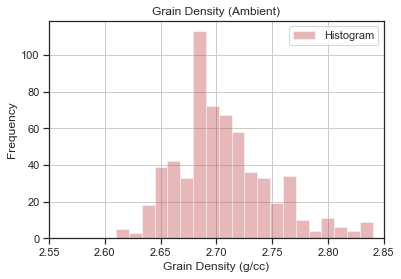

In [18]:
savefn = "Hist_GD_amb.png"

## fuction to plot - usage
## plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)
plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Ambient)", 20, 2.55, 2.85, savefn)

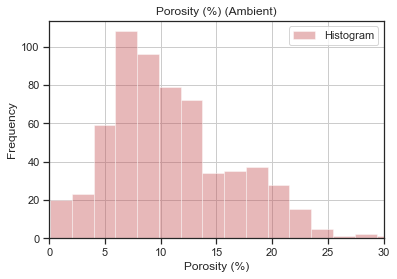

In [19]:
savefn = "Hist_Poro_amb.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (Ambient)", 20, 0, 30, savefn)

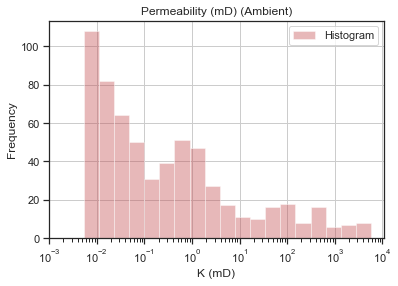

In [20]:
savefn = "Hist_Perm_amb.png"

x= df_sub["K (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K (mD)"], "Permeability (mD) (Ambient)", logbins, 0.001, x.max()+5000, savefn)
plt.xscale('log')

#### Plot cross-plot of Porosity-Permeability

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1099: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


Equation of line:  
0
Intercept: 0.0
Gradient Coefficient: 0.0


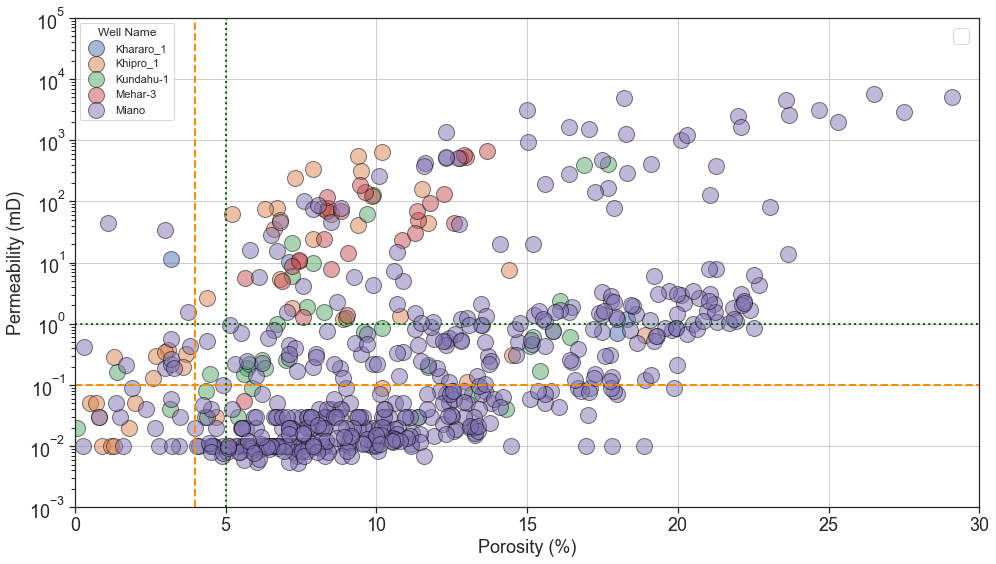

In [22]:
savefn = "Poro_Perm_amb.png"

xlimit = 30
ylimit = 100000

#Cutoff intercept
yint1 = 0.1
xint1 = 4

yint2 = 1
xint2 = 5

plot_line_eqn = False

f, p0, p1 = plot_PP(df_sub, grouped, color, 
                    "Ambient Porosity vs Permeability", savefn, xint1, yint1, 
                    xint2, yint2, xlimit, ylimit, plot_line_eqn)
print("Equation of line:", f)
print("Intercept:", p0)
print("Gradient Coefficient:", p1)

##### Cross-plot for values at overburden

df_sub = mod_df[mod_df['NOB (psi)'] > NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

savefn = "Hist_GD_OB.png"

# fuction to plot - usage
# plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max, savefile_name)

plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (Overburden)", 20, 2.55, 2.9, savefn)

savefn = "Hist_Poro_OB.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (Overburden)", 20, 0, 35, savefn)

savefn = "Hist_Perm_OB.png"

x= df_sub["K (mD)"]

logbins = np.geomspace(x.min(), x.max(), 20)
plot_grain_density(df_sub["K (mD)"], "Permeability (mD) (Ambient)", logbins, 0.01, x.max()+1000, savefn)
plt.xscale('log')

savefn = "Poro_Perm_Overburden.png"

xlimit = 35
ylimit = 10000

#Cutoff intercept
yint1 = 1
xint1 = 16

yint2 = 0.1
xint2 = 12

plot_line_eqn = True

f, p0, p1 = plot_PP(df_sub, grouped, color, 
                    "Overburden Porosity vs Permeability", savefn, 
                    xint1, yint1, xint2, yint2, xlimit, ylimit, plot_line_eqn)
print("Equation of line:", f)
print("Intercept:", p0)
print("Gradient Coefficient:", p1)


### K means clustering of Core Data

#### Step 1: Normalise Data Set

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#### Step 1: Elbow Plot

In [ ]:
mod_df_copy = mod_df.copy()
mod_df_copy.columns.values

In [ ]:
# Select columns to do prediction on
X_drop = mod_df_copy.drop(['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)',
                           #'Grain Density (g/cc)', 
                           'Core Type', 'color'], axis = 1)

In [ ]:
distortions = []

min_el = 1
max_el = 10

# A loop runs thorugh your min and max clusters. 
# We dont complicate the K-Means at this stage
# We store an "intertia" number which is the measurement of the distortions in different K clustering solutions

for i in range (min_el,max_el):
    km = KMeans(n_clusters= i, init = "k-means++")
    km.fit(X_drop)
    distortions.append(km.inertia_)  

In [ ]:
# elbow curve
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150)
plt.plot(range (min_el,max_el), distortions, marker='o', markersize=5,
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

#### Looks like 3 is the optimal number of clusters. Lets do the K means proper now

#### Step 2: K-means Plot

In [ ]:
# This normalizes the data set
scaler = preprocessing.StandardScaler()
scaler.fit(X_drop)
X_drop_Norm = scaler.transform(X_drop)

# Now we convert to a pandas array
#car_norm_price = pd.DataFrame(X_drop_Norm, columns = DF_model_toNorm_colnam, index = DF_model_toNorm_rownam)
#car_norm_price

In [ ]:
# Fitting the K-Means with the optimal number of cluster
k = 3
km = KMeans(n_clusters=k, init = "k-means++", random_state = 0)
km_fit = km.fit(X_drop_Norm)

# Predicting the Classificaiton of the Data
y_pred = km.fit_predict(X_drop_Norm)
display(y_pred)

In [ ]:
# The predicted results should now be converted to a pandas dataframe
y_pred_data = pd.DataFrame({"cluster":y_pred},index = X_drop.index)
y_pred_data

In [ ]:
core_pred = pd.concat([X_drop , y_pred_data], axis = 1)
core_pred

In [ ]:
names = core_pred['cluster'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

core_pred['color'] = core_pred['cluster'].apply(lambda x: colors[x])
core_pred = core_pred.sort_values(by = 'Porosity (%)', ascending = True)
core_pred

In [ ]:
pd.crosstab(core_pred['Porosity (%)'], core_pred['cluster'], normalize='index', margins = True)

In [ ]:
filtered_label0 = core_pred[core_pred['cluster'] == 0]
filtered_label1 = core_pred[core_pred['cluster'] == 1]
filtered_label2 = core_pred[core_pred['cluster'] == 2]
#filtered_label3 = core_pred[core_pred['cluster'] == 3]

In [ ]:
fs = 12

#markers - https://matplotlib.org/stable/api/markers_api.html
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3), dpi = 150,)
plt.scatter(filtered_label0['Porosity (%)'], filtered_label0['K (mD)'], marker='o')
plt.scatter(filtered_label1['Porosity (%)'], filtered_label1['K (mD)'], marker='v')
plt.scatter(filtered_label2['Porosity (%)'], filtered_label2['K (mD)'], marker='+')
#plt.scatter(filtered_label3['Porosity (%)'], filtered_label3['K (mD)'], marker='s')

x_pts = list(range(0,20,1))

#Line styles - https://matplotlib.org/2.0.2/api/lines_api.html
p = np.polyfit(np.log(filtered_label0['Porosity (%)']), np.log(filtered_label0['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-', linewidth = 1.5)
plt.text(12.5, 15, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label1['Porosity (%)']), np.log(filtered_label1['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k--', linewidth = 1.5)
plt.text(6, 0.5, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.25))

p = np.polyfit(np.log(filtered_label2['Porosity (%)']), np.log(filtered_label2['K (mD)']), 1)
f = np.poly1d(p)
plt.semilogy(x_pts, np.exp(p[0] * np.log(x_pts) + p[1]), 'k-.', linewidth = 1.5)
plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

# p = np.polyfit(np.log(filtered_label3['Porosity (%)']), np.log(filtered_label3['K (mD)']), 1)
# f = np.poly1d(p)
# plt.semilogy(filtered_label3['Porosity (%)'], np.exp(p[0] * np.log(filtered_label3['Porosity (%)']) + p[1]), 'k.', linewidth = 1.5)
# plt.text(17.8, 200, r'Equation ={}'.format(f), fontsize = fs/1.5, bbox=dict(facecolor='white', alpha=0.5))

plt.yscale('log')
plt.xlim(0, xlimit)
plt.ylim(1, ylimit)
plt.xticks(fontsize=fs-3)
plt.xlabel('Porosity (%)',fontsize=fs)
plt.ylabel('Permeability (mD)',fontsize=fs)
plt.title('Cluster Distribution',fontsize=fs+2)
plt.grid(True)

plt.savefig('Cluster_Dist.png', transparent=True)

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))